In [1]:
import seaborn as sns


In [2]:
import numpy as np
import pandas as pd
# For visualizations
import matplotlib.pyplot as plt
# For regular expressions
import re
# For handling string
import string
# For performing mathematical operations
import math


# Importing dataset
df=pd.read_csv('scrapped_data.csv')
print("Shape of data=>",df.shape)

Shape of data=> (4062, 4)


In [3]:
df=df[['Rating','Review']]#getting required columns
print("Shape of data=>",df.shape)
df.head(5)

Shape of data=> (4062, 2)


,Rating,Review
0,3,Good
1,4,Nice t shirt
2,5,Good product
3,3,Pooar quality
4,5,Good product


In [4]:
df.isnull().sum() #to check null values


Rating    0
Review    0
dtype: int64

In [5]:
df.dropna(inplace=True)#to remove null values if there
df.isnull().sum()

Rating    0
Review    0
dtype: int64

In [6]:
df['cleaned']=df['Review'].apply(lambda x: x.lower()) #to lower letter
df['cleaned']=df['cleaned'].apply(lambda x: re.sub('\w*\d\w*','', x))#remove digits in data
df['cleaned']=df['cleaned'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))#Remove Punctuations
df['cleaned']=df['cleaned'].apply(lambda x: re.sub(' +',' ',x))# Removing extra spaces
for index,text in enumerate(df['cleaned'][35:40]):
  print('Review %d:\n'%(index+1),text)#how it looks after cleaning


Review 1:
 good my son like it
Review 2:
 nice
Review 3:
 nice
Review 4:
 terrific purchase
Review 5:
 amazing


In [7]:
#stopwords removal and lemmatization
# Importing spacy
import spacy

# Loading model
nlp = spacy.load('en_core_web_sm',disable=['parser', 'ner'])

# Lemmatization with stopwords removal
df['lemmatized']=df['cleaned'].apply(lambda x: ' '.join([token.lemma_ for token in list(nlp(x)) if (token.is_stop==False)]))


In [8]:
df=df[['Rating','lemmatized']]
df_new=df.rename(columns={'lemmatized':'Review'})
df=df_new

In [9]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
sent = SentimentIntensityAnalyzer()
sentiment_dict = []
for i in range(0,len(df)):
 sentiment_dict.append(sent.polarity_scores(df.iloc[i,1]))
positive = []
neutral = []
negative = []
compound = []
for item in sentiment_dict:
 positive.append(item['pos'])
 neutral.append(item['neu'])
 negative.append(item['neg'])
 compound.append(item['compound'])
sentiment_df = pd.DataFrame(list(zip(positive, neutral, negative, compound)), columns = ['Positive', 'Neutral', 'Negative', 'Compound'])
 
df['Positive'] = sentiment_df['Positive']
df['Negative'] = sentiment_df['Negative']
df['Neutral'] = sentiment_df['Neutral']
df['Compound'] = sentiment_df['Compound']

In [10]:
#dataframe after appending
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4062 entries, 0 to 4061
Data columns (total 6 columns):
Rating      4062 non-null int64
Review      4062 non-null object
Positive    4062 non-null float64
Negative    4062 non-null float64
Neutral     4062 non-null float64
Compound    4062 non-null float64
dtypes: float64(4), int64(1), object(1)
memory usage: 382.1+ KB


In [11]:
df['Positive'].mean()*10

6.520199409158119

In [12]:
df['Neutral'].mean()*10

2.643574593796151

In [13]:
df['Negative'].mean()*10

0.8189955686853772

In [14]:
df_temp=df[['Rating','Review']]

In [15]:
df_temp=df_temp.assign(new="1")


In [16]:
df_temp.head()

,Rating,Review,new
0,3,good,1
1,4,nice t shirt,1
2,5,good product,1
3,3,pooar quality,1
4,5,good product,1


In [17]:
df_grouped=df_temp[['new','Review']].groupby(by='new').agg(lambda x:' '.join(x))
df_grouped.head()

,Review
new,
1,good nice t shirt good product pooar quality g...


In [18]:
# Creating Document Term Matrix
from sklearn.feature_extraction.text import CountVectorizer 
cv=CountVectorizer(analyzer='word')
data=cv.fit_transform(df_grouped['Review'])
df_dtm = pd.DataFrame(data.toarray(), columns=cv.get_feature_names())
df_dtm.index=df_grouped.index
df_dtm


,able,absolute,absolutely,acceceprd,accept,acceptable,accord,accordance,accordingly,accurate,...,xl,xxl,ya,yaar,year,yellowish,yha,yrrr,zing,ñicè
new,,,,,,,,,,,,,,,,,,,,,
1,1,1,3,1,1,1,5,1,1,1,...,2,2,1,1,1,1,1,1,2,1


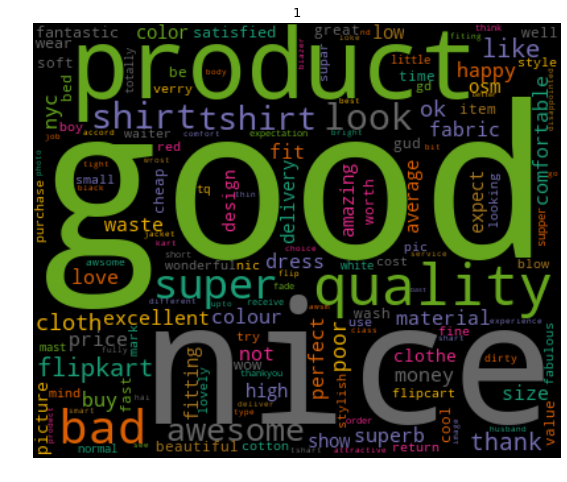

In [19]:
# Importing wordcloud for plotting word clouds and textwrap for wrapping longer text
from wordcloud import WordCloud
from textwrap import wrap

# Function for generating word clouds
def generate_wordcloud(data,title):
  wc = WordCloud(width=400, height=330, max_words=150,colormap="Dark2").generate_from_frequencies(data)
  plt.figure(figsize=(10,8))
  plt.imshow(wc, interpolation='bilinear')
  plt.axis("off")
  plt.title('\n'.join(wrap(title,60)),fontsize=13)
  plt.show()
  
# Transposing document term matrix
df_dtm=df_dtm.transpose()

# Plotting word cloud for each product
for index,product in enumerate(df_dtm.columns):
  generate_wordcloud(df_dtm[product],product)

In [20]:
from textblob import TextBlob
df['polarity']=df['Review'].apply(lambda x:TextBlob(x).sentiment.polarity)

In [21]:
print("3 Random Reviews with Highest Polarity:")
for index,Review in enumerate(df.iloc[df['polarity'].sort_values(ascending=False)[:3].index]['Review']):
  print('Review {}:\n'.format(index+1),Review)

3 Random Reviews with Highest Polarity:
Review 1:
 awesome t shirt
Review 2:
 excellent
Review 3:
 awesome product


In [22]:
print("3 Random Reviews with Lowest Polarity:")
for index,Review in enumerate(df.iloc[df['polarity'].sort_values(ascending=True)[:3].index]['Review']):
  print('Review {}:\n'.format(index+1),Review)

3 Random Reviews with Lowest Polarity:
Review 1:
 nasty
Review 2:
 worst material
Review 3:
 disgusting
